In [1]:
# CELL 1: Import Libraries and Environment Setup with Unified Schema & Visualization Support
import os
import re
import platform
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import easyocr
import zipcodes

plt.style.use("ggplot")

EXPECTED_COLUMNS = [
    "serial_number",
    "event_type",
    "date",
    "associated_name",
    "associated_address",
    "filename",
    "file_creation_date",
    "file_modification_date",
    "file_location",
]
_reader_instance = None


def get_easyocr_reader(langs=("en",)):
    global _reader_instance
    if _reader_instance is None:
        try:
            _reader_instance = easyocr.Reader(list(langs))
        except Exception as e:
            print(f"EasyOCR initialization failed: {e}")
            _reader_instance = None
    return _reader_instance


def ensure_schema(df: pd.DataFrame) -> pd.DataFrame:
    for col in EXPECTED_COLUMNS:
        if col not in df.columns:
            df[col] = None
    return df[EXPECTED_COLUMNS].copy()


if "df1" not in globals():
    df1 = pd.DataFrame(columns=EXPECTED_COLUMNS)
else:
    df1 = ensure_schema(df1)

print("Environment setup complete with target schema:")
print(EXPECTED_COLUMNS)

# Visualization helper with semantic highlighting
CATEGORY_COLORS = {
    "serial": (0, 255, 0),  # Green
    "event_type": (255, 140, 0),  # Dark Orange
    "name": (30, 144, 255),  # Dodger Blue
    "address": (148, 0, 211),  # Dark Violet
    "other": (0, 0, 255),  # Red
}


def classify_token(text_lower):
    # Lightweight classification for event_type cues / names / address parts
    event_keywords = [
        "inventory",
        "inspection",
        "theft",
        "loss",
        "stolen",
        "missing",
        "burglary",
        "incident",
        "transfer",
        "disposal",
    ]
    address_keywords = [
        "street",
        "st",
        "ave",
        "road",
        "rd",
        "dr",
        "drive",
        "lane",
        "ln",
        "blvd",
        "suite",
        "ste",
        "apt",
        "unit",
    ]
    if any(k in text_lower for k in event_keywords):
        return "event_type"
    if re.fullmatch(r"[a-z]+,?", text_lower) and text_lower.istitle() is False:
        # fallback simple heuristic
        return "other"
    if any(k == text_lower for k in address_keywords):
        return "address"
    return "other"


def visualize_ocr(
    img_bgr,
    ocr_results,
    serial_candidate=None,
    metadata_info=None,
    show=True,
    title=None,
):
    draw = img_bgr.copy()
    serial_norm = str(serial_candidate) if serial_candidate else None
    name_parts = set()
    if metadata_info and metadata_info.get("name"):
        for part in str(metadata_info["name"]).split():
            name_parts.add(part.lower())
    address_tokens = set()
    if metadata_info and metadata_info.get("complete_address"):
        for part in re.split(r"[\s,]", str(metadata_info["complete_address"])):
            if part:
                address_tokens.add(part.lower())
    for bbox, text, conf in ocr_results:
        t_norm = text.strip()
        t_lower = t_norm.lower()
        if serial_norm and t_norm == serial_norm:
            color_key = "serial"
        elif t_lower in name_parts:
            color_key = "name"
        elif t_lower in address_tokens:
            color_key = "address"
        else:
            color_key = classify_token(t_lower)
        color = CATEGORY_COLORS.get(color_key, CATEGORY_COLORS["other"])
        pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
        cv2.polylines(
            draw,
            [pts],
            isClosed=True,
            color=color,
            thickness=2 if color_key != "serial" else 3,
        )
        x, y = pts[0][0]
        label = f"{t_norm} ({conf:.2f})"
        cv2.putText(
            draw,
            label[:38],
            (x, y - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.55,
            color,
            2,
            cv2.LINE_AA,
        )
    if show:
        img_rgb = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(13, 9))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(
            title
            or "OCR Visualization (serial=green, event=orange, name=blue, addr=violet)"
        )
        plt.show()
    return draw


Environment setup complete with target schema:
['serial_number', 'event_type', 'date', 'associated_name', 'associated_address', 'filename', 'file_creation_date', 'file_modification_date', 'file_location']


In [2]:
# CELL 2: Metadata Extraction
import os
import platform
from datetime import datetime


def get_file_metadata(file_path):
    """Get comprehensive file metadata - platform agnostic, honest timestamps"""
    try:
        file_stats = os.stat(file_path)
        system = platform.system().lower()

        # Platform-specific creation time handling - report what the OS actually provides
        if system == "windows":
            # Windows: st_ctime is actual creation time
            creation_time = file_stats.st_ctime
            creation_source = "st_ctime (Windows creation time)"
            creation_reliable = True
        elif hasattr(file_stats, "st_birthtime"):
            # macOS/BSD: st_birthtime is true creation time
            creation_time = file_stats.st_birthtime
            creation_source = "st_birthtime (macOS/BSD creation time)"
            creation_reliable = True
        else:
            # Linux/Other: No reliable creation time available
            # Report st_ctime but mark as unreliable
            creation_time = file_stats.st_ctime
            creation_source = "st_ctime (Linux - metadata change time, NOT creation)"
            creation_reliable = False

        # Modification time is consistent across platforms
        modification_time = file_stats.st_mtime

        metadata = {
            "filename": os.path.basename(file_path),
            "file_creation_date": datetime.fromtimestamp(creation_time).strftime(
                "%Y-%m-%d %H:%M:%S"
            ),
            "file_modification_date": datetime.fromtimestamp(
                modification_time
            ).strftime("%Y-%m-%d %H:%M:%S"),
            "file_location": os.path.abspath(file_path),
            "platform": system,
            "creation_source": creation_source,
            "creation_reliable": creation_reliable,  # Indicates if creation time is trustworthy
        }

        return metadata

    except Exception as e:
        print(f"Error getting metadata for {file_path}: {e}")
        return {
            "filename": os.path.basename(file_path) if file_path else "Unknown",
            "file_creation_date": "Unknown",
            "file_modification_date": "Unknown",
            "file_location": (
                os.path.abspath(file_path)
                if file_path and os.path.exists(file_path)
                else str(file_path)
            ),
            "platform": platform.system().lower(),
            "creation_source": "Error occurred",
            "creation_reliable": False,
        }


# Optional: Diagnostic function to show what timestamps are actually available
def diagnose_file_timestamps(file_path):
    """Show all available timestamps for debugging"""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    try:
        file_stats = os.stat(file_path)
        system = platform.system().lower()

        print(f"\nFile: {os.path.basename(file_path)}")
        print(f"Platform: {system}")
        print("\nAvailable timestamps:")

        if hasattr(file_stats, "st_birthtime"):
            print(
                f"  st_birthtime: {datetime.fromtimestamp(file_stats.st_birthtime).strftime('%Y-%m-%d %H:%M:%S')} (creation time)"
            )
        else:
            print("  st_birthtime: Not available")

        print(
            f"  st_ctime:     {datetime.fromtimestamp(file_stats.st_ctime).strftime('%Y-%m-%d %H:%M:%S')} ({'creation' if system == 'windows' else 'metadata change'} time)"
        )
        print(
            f"  st_mtime:     {datetime.fromtimestamp(file_stats.st_mtime).strftime('%Y-%m-%d %H:%M:%S')} (modification time)"
        )
        print(
            f"  st_atime:     {datetime.fromtimestamp(file_stats.st_atime).strftime('%Y-%m-%d %H:%M:%S')} (access time)"
        )

    except Exception as e:
        print(f"Error reading timestamps: {e}")


Found 1 BMP files in test folder


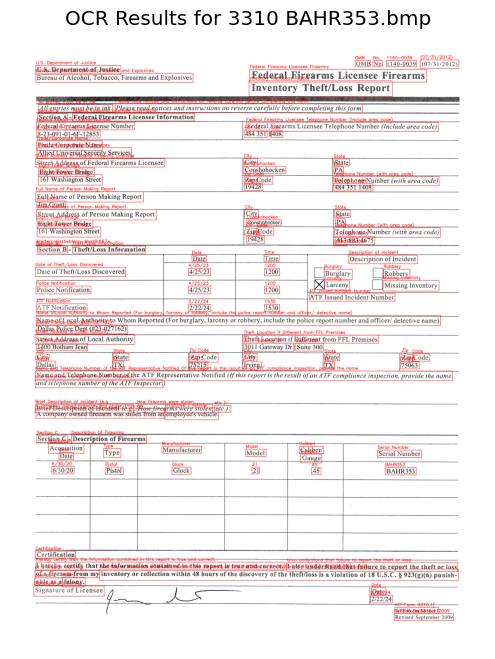

✓ Processed: 3310 BAHR353.bmp | Serial: BAHR353 | Event: Theft/Loss | Date: 4/25/23 | Name: Jim Grant | Street: 161 Washington Street | Zip: 19428 | City: Conshohocken | State: PA | CompleteAddr: 161 Washington Street, Conshohocken, PA 19428

BMP processing complete!
EXTRACTION RESULTS (CSV FORMAT)
serial_number,event_type,event_date,associated_name,associated_address,source_file,file_created,file_modified
BAHR353,Theft/Loss,4/25/23,Jim Grant,"161 Washington Street, Conshohocken, PA 19428",test/3310 BAHR353.bmp,2025-08-04 03:57:38,2025-08-04 03:57:38



In [3]:
# CELL 3: BMP files processing

import os
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import pandas as pd
import re
import zipcodes

# Setup
df1["filename"] = df1["filename"].astype(str)
df1["file_creation_date"] = df1["file_creation_date"].astype(str)
df1["file_modification_date"] = df1["file_modification_date"].astype(str)
df1["file_location"] = df1["file_location"].astype(str)

test_folder = os.path.join(os.getcwd(), "test")
reader = easyocr.Reader(["en"], gpu=True)
file_list = [f for f in os.listdir(test_folder) if f.lower().endswith(".bmp")]

print(f"Found {len(file_list)} BMP files in test folder")

# Initialize results list for CSV output
csv_results = []


def combine_spaced_alphanumeric(text):
    """Combine spaced alphanumeric characters that form a sequence"""
    parts = [part for part in text.split() if part]
    if len(parts) >= 3:
        single_chars = [
            part
            for part in parts
            if len(part) == 1 and (part.isalpha() or part.isdigit())
        ]
        if len(single_chars) >= 2:
            combined = "".join(parts)
            if 5 <= len(combined) <= 20 and combined.isalnum():
                return combined
    return text


def find_serial(processed_results, all_text_combined, original_results):
    """Find serial number using multiple strategies"""
    patterns = [
        r"\b[A-Z0-9]{7,12}\b",
        r"\b[A-Z0-9]{4,20}\b",
        r"\b[A-Z]{1,2}[0-9]{4,10}\b",
        r"\b[0-9]{4,15}\b",
        r"\b[A-Z]{2,10}[0-9]{2,10}\b",
        r"\b[A-Z]{3,15}\b",
        r"\b[0-9]{5,15}\b",
    ]

    # Try processed results first
    for pattern in patterns:
        for bbox, text, confidence in processed_results:
            match = re.search(pattern, text)
            if match:
                candidate = match.group()
                if (
                    5 <= len(candidate) <= 20
                    and candidate.lower()
                    not in ["image", "photo", "document", "serial", "number"]
                    and candidate.isalnum()
                ):
                    return candidate

    # Try combined text
    if all_text_combined:
        for pattern in patterns:
            match = re.search(pattern, all_text_combined)
            if match:
                candidate = match.group()
                if 5 <= len(candidate) <= 20 and candidate.isalnum():
                    return candidate

    # Try spaced reconstruction
    for bbox, text, confidence in original_results:
        if " " in text and len(text.split()) >= 3:
            parts = text.split()
            single_chars = [p for p in parts if len(p) == 1]
            if len(single_chars) >= 3:
                reconstructed = "".join(parts)
                if 5 <= len(reconstructed) <= 20 and reconstructed.isalnum():
                    return reconstructed

    return None


def extract_metadata(processed_results):
    """Extract name, address, date, zipcode, city, state, and event name"""

    # Business/organization names to exclude when looking for person names
    business_exclusions = [
        "federal",
        "firearms",
        "gun",
        "shop",
        "store",
        "company",
        "corp",
        "corporation",
        "inc",
        "incorporated",
        "llc",
        "ltd",
        "limited",
        "business",
        "enterprise",
        "arms",
        "armory",
        "tactical",
        "shooting",
        "sports",
        "outdoor",
        "hunting",
        "dealer",
        "sales",
        "supply",
        "equipment",
        "services",
        "solutions",
    ]

    results = {}
    matches = 0

    # Extract street address
    street_address = None
    address_pattern = r"\b\d{1,5}\s[A-Z][a-z]+\s[A-Z][a-z]+\b"
    for bbox, text, confidence in processed_results:
        match = re.search(address_pattern, text)
        if match:
            street_address = match.group()
            matches += 1
            break

    results["street_address"] = street_address

    # Special handling for person name extraction
    name = None
    name_candidates = []

    # Look for person name patterns (2-3 words, proper case)
    name_patterns = [
        r"\b[A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+\b",  # First Middle Last
        r"\b[A-Z][a-z]+\s[A-Z]\.\s[A-Z][a-z]+\b",  # First M. Last
        r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b",  # First Last
    ]

    for pattern in name_patterns:
        for bbox, text, confidence in processed_results:
            matches_found = re.findall(pattern, text)
            for match in matches_found:
                # Check if this looks like a person name (not business)
                match_lower = match.lower()
                is_business = any(
                    exclusion in match_lower for exclusion in business_exclusions
                )

                if not is_business and confidence > 0.7:
                    name_candidates.append((match, confidence))

    # Select the best name candidate
    if name_candidates:
        # Sort by confidence and prefer longer names (likely more complete)
        name_candidates.sort(key=lambda x: (x[1], len(x[0])), reverse=True)
        name = name_candidates[0][0]
        matches += 1

    results["name"] = name

    # Semantic event name extraction - focus on actual events, not form metadata
    event_name = None
    event_candidates = []

    # Words to exclude (organizational/administrative terms, not events)
    excluded_words = {
        "atf",
        "bureau",
        "federal",
        "department",
        "justice",
        "alcohol",
        "tobacco",
        "firearms",
        "explosives",
        "form",
        "section",
        "page",
        "number",
        "code",
        "licensee",
        "information",
        "details",
        "description",
        "brief",
        "name",
        "address",
        "telephone",
        "date",
        "time",
        "signature",
        "certification",
    }

    # PRIORITY 1: Look for document purpose indicators (what is being reported)
    purpose_patterns = [
        (
            r"(Theft|Loss|Stolen|Missing|Burglary|Robbery|Larceny).*?Report",
            "Theft/Loss",
        ),
        (r"Inventory\s+(Theft|Loss)", "Theft/Loss"),
        (
            r"(Purchase|Sale|Transfer|Registration|Acquisition|Disposition).*?Report",
            None,
        ),
    ]

    for pattern, fixed_event in purpose_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.4:
                if fixed_event:
                    event_type = fixed_event
                else:
                    event_type = match.group(1).title()
                event_candidates.append(
                    (event_type, confidence + 1.0, "document_purpose")
                )

    # PRIORITY 2: Look for specific incident/crime types
    incident_types = {
        "burglary": "Burglary",
        "robbery": "Robbery",
        "larceny": "Larceny",
        "theft": "Theft",
        "stolen": "Theft",
        "missing": "Missing",
        "lost": "Loss",
    }

    for i, (bbox, text, confidence) in enumerate(processed_results):
        text_clean = text.lower().strip()
        if text_clean in incident_types and confidence > 0.5:
            event_candidates.append(
                (incident_types[text_clean], confidence + 0.8, "incident_type")
            )

    # PRIORITY 3: Look for action descriptions (what happened to the firearm)
    action_patterns = [
        (r"was\s+(stolen|taken|missing|lost)", None),
        (r"were\s+(stolen|taken|missing|lost)", None),
        (r"firearm\s+was\s+(\w+)", None),
        (r"gun\s+was\s+(\w+)", None),
    ]

    for pattern, _ in action_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.6:
                action = match.group(1).lower()
                if action in incident_types:
                    event_candidates.append(
                        (incident_types[action], confidence + 0.6, "action_description")
                    )

    # PRIORITY 4: Look for section headers that indicate event type
    section_patterns = [
        (r"(Theft|Loss|Stolen|Missing)\s+Information", None),
        (r"(Purchase|Sale|Transfer)\s+Information", None),
    ]

    for pattern, _ in section_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.6:
                event_type = match.group(1).title()
                if event_type.lower() not in excluded_words:
                    event_candidates.append(
                        (event_type, confidence + 0.4, "section_header")
                    )

    # PRIORITY 5: Look for meaningful single words (but filter out administrative terms)
    for i, (bbox, text, confidence) in enumerate(processed_results):
        text_clean = text.strip()
        if (
            len(text_clean.split()) == 1
            and len(text_clean) > 3
            and confidence > 0.7
            and text_clean.isalpha()
            and text_clean.lower() not in excluded_words
        ):
            # Check if it's a potential event type
            if text_clean.lower() in incident_types:
                event_candidates.append(
                    (
                        incident_types[text_clean.lower()],
                        confidence + 0.2,
                        "meaningful_word",
                    )
                )

    # Select the best event candidate with semantic priority
    if event_candidates:
        # Sort by: 1) Source priority (semantic importance), 2) Confidence
        priority_order = {
            "document_purpose": 5,  # Highest - what the document is for
            "incident_type": 4,  # High - specific crime/incident type
            "action_description": 3,  # Medium-high - what happened
            "section_header": 2,  # Medium - section context
            "meaningful_word": 1,  # Low - single words
        }

        event_candidates.sort(
            key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
        )

        event_name = event_candidates[0][0]
        matches += 1

    results["event_name"] = event_name

    # Extract event date - look for explicit event date labels, then find nearby dates
    event_date = None
    date_candidates = []

    # PRIORITY 1: Look for explicit event date labels, then find nearby dates
    event_label_patterns = [
        r"Date\s+of\s+(Theft|Loss|Stolen|Missing|Incident|Crime)",
        r"(Theft|Loss|Stolen|Missing|Incident|Crime)\s+.*?Date",
        r"When\s+.*?(stolen|lost|missing|taken)",
        r"Date.*?(Discovered|Reported|Occurred)",
    ]

    # First, find text blocks with event date labels
    event_label_positions = []
    for bbox, text, confidence in processed_results:
        for pattern in event_label_patterns:
            if re.search(pattern, text, re.IGNORECASE) and confidence > 0.4:
                text_y = min([point[1] for point in bbox])
                event_label_positions.append((text_y, text, confidence))
                break

    # Then, find dates near these labels
    if event_label_positions:
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                date_y = min([point[1] for point in bbox])

                # Find the closest event label to this date
                for label_y, label_text, label_conf in event_label_positions:
                    y_distance = abs(date_y - label_y)
                    if y_distance < 150:  # Within 150 pixels of event label
                        date_candidates.append(
                            (
                                date_match.group(),
                                confidence + 1.0,
                                "explicit_event_context",
                                f"Near label: {label_text}",
                            )
                        )

    # PRIORITY 2: Look for dates near event-related text (if no explicit labels found)
    if not date_candidates:
        event_keywords = [
            "theft",
            "loss",
            "stolen",
            "missing",
            "larceny",
            "burglary",
            "incident",
        ]

        # Find text blocks containing event keywords
        event_text_positions = []
        for i, (bbox, text, confidence) in enumerate(processed_results):
            text_lower = text.lower()
            if (
                any(keyword in text_lower for keyword in event_keywords)
                and confidence > 0.5
            ):
                text_y = min([point[1] for point in bbox])
                event_text_positions.append((i, text_y, text))

        # Look for dates near event-related text
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                text_y = min([point[1] for point in bbox])

                # Check if this date is near any event-related text
                for event_i, event_y, event_text in event_text_positions:
                    y_distance = abs(text_y - event_y)
                    if y_distance < 100:  # Within 100 pixels of event text
                        date_candidates.append(
                            (
                                date_match.group(),
                                confidence + 0.8,
                                "near_event_text",
                                f"Near: {event_text}",
                            )
                        )

    # PRIORITY 3: Exclude administrative dates
    administrative_keywords = [
        "atf",
        "notification",
        "form",
        "created",
        "printed",
        "letterhead",
        "bureau",
    ]

    # Filter out dates that are clearly administrative
    filtered_candidates = []
    for date_val, conf, source, context in date_candidates:
        context_lower = context.lower()
        is_administrative = any(
            admin_word in context_lower for admin_word in administrative_keywords
        )

        if not is_administrative:
            filtered_candidates.append((date_val, conf, source, context))

    # Select the best event date
    if filtered_candidates:
        # Sort by source priority, then confidence
        priority_order = {
            "explicit_event_context": 3,  # Highest - explicit event date labels
            "near_event_text": 2,  # Medium - dates near event descriptions
            "positional": 1,  # Lowest - just positional filtering
        }

        filtered_candidates.sort(
            key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
        )
        event_date = filtered_candidates[0][0]
        matches += 1

        # DEBUG: Uncomment to see date selection process
        # print(f"Event date selected: '{event_date}' from {filtered_candidates[0][2]} - Context: {filtered_candidates[0][3]}")

    elif date_candidates:
        # Fallback to any date found, but still avoid administrative ones
        event_date = date_candidates[0][0]
        matches += 1
    else:
        # Final fallback: any date in the document (existing logic)
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                event_date = date_match.group()
                matches += 1
                break

    results["event_date"] = event_date

    # Zipcode with positional filtering
    zipcode = None
    if processed_results:
        all_y_coords = [point[1] for bbox, _, _ in processed_results for point in bbox]
        image_height = max(all_y_coords) if all_y_coords else 0
        top_boundary = image_height * 0.25
        bottom_boundary = image_height * 0.50

        candidates = []
        for bbox, text, confidence in processed_results:
            if re.match(r"\b\d{5}(-\d{4})?\b", text.strip()):
                top_y = min([point[1] for point in bbox])
                bottom_y = max([point[1] for point in bbox])
                text_center_y = (top_y + bottom_y) / 2
                if top_boundary <= text_center_y <= bottom_boundary:
                    candidates.append((text.strip(), confidence))

        if candidates:
            zipcode = max(candidates, key=lambda x: x[1])[0]
            matches += 1

    # Get city/state from zipcode
    city = state = None
    if zipcode:
        try:
            location = zipcodes.matching(str(zipcode))
            if location:
                city = location[0]["city"]
                state = location[0]["state"]
                matches += 2
        except Exception as e:
            print(f"Error looking up zipcode {zipcode}: {e}")

    # Construct complete address
    complete_address = ""
    if street_address:
        complete_address = street_address
        if city and state:
            complete_address += f", {city}, {state}"
            if zipcode:
                complete_address += f" {zipcode}"
        elif zipcode:
            complete_address += f" {zipcode}"

    results.update(
        {
            "complete_address": complete_address,
            "zipcode": zipcode,
            "city": city,
            "state": state,
            "matches": matches,
        }
    )
    return results


# Main processing loop
for filename in file_list:
    full_path = os.path.join(test_folder, filename)
    relative_path = os.path.join("test", filename)  # Create relative path
    # print(f"\nProcessing BMP: {filename}")

    try:
        # Load BMP with OpenCV and convert for EasyOCR
        img_cv = cv2.imread(full_path)
        if img_cv is not None and isinstance(img_cv, np.ndarray):
            img_for_ocr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            results = reader.readtext(img_for_ocr)
        else:
            print(f"Failed to load BMP file {filename}")
            results = []

        # Visualize results (comment out if not needed)
        img = cv2.imread(full_path)
        if img is not None and isinstance(img, np.ndarray):
            for bbox, text, confidence in results:
                pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)
                x, y = pts[0][0]
                cv2.putText(
                    img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2
                )

            try:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 8))
                plt.imshow(img_rgb)
                plt.axis("off")
                plt.title(f"OCR Results for {filename}")
                plt.show()
            except Exception as e:
                print(f"Warning: Could not display image {filename}")

        # Process OCR results
        processed_results = []
        for bbox, text, confidence in results:
            processed_text = combine_spaced_alphanumeric(text)
            processed_results.append((bbox, processed_text, confidence))

        all_text_combined = " ".join([text for _, text, _ in processed_results])

        # Find serial number
        serial_num = find_serial(processed_results, all_text_combined, results)

        # Extract metadata
        metadata_info = extract_metadata(processed_results)

        # Get file metadata using absolute path but store relative path
        file_metadata = get_file_metadata(full_path)

        # Create CSV record with fixed address and event date
        csv_record = {
            "serial_number": str(serial_num) if serial_num else "",
            "event_type": (
                str(metadata_info["event_name"]) if metadata_info["event_name"] else ""
            ),
            "event_date": (
                str(metadata_info["event_date"]) if metadata_info["event_date"] else ""
            ),
            "associated_name": (
                str(metadata_info["name"]) if metadata_info["name"] else ""
            ),
            "associated_address": (
                str(metadata_info["complete_address"])
                if metadata_info["complete_address"]
                else ""
            ),
            "source_file": relative_path,
            "file_created": file_metadata["file_creation_date"],
            "file_modified": file_metadata["file_modification_date"],
        }

        csv_results.append(csv_record)

        # Add to dataframe (including event_name)
        new_row = {
            "serial_number": str(serial_num) if serial_num else None,
            "name": str(metadata_info["name"]) if metadata_info["name"] else None,
            "address": (
                str(metadata_info["street_address"])
                if metadata_info["street_address"]
                else None
            ),
            "date": (
                str(metadata_info["event_date"])
                if metadata_info["event_date"]
                else None
            ),
            "zipcode": (
                str(metadata_info["zipcode"]) if metadata_info["zipcode"] else None
            ),
            "city": str(metadata_info["city"]) if metadata_info["city"] else None,
            "state": str(metadata_info["state"]) if metadata_info["state"] else None,
            "event_name": (
                str(metadata_info["event_name"])
                if metadata_info["event_name"]
                else None
            ),
        }

        df1 = pd.concat([df1, pd.DataFrame([new_row])], ignore_index=True)

        # Add file metadata to df1 with relative path
        if serial_num:
            df1.loc[df1["serial_number"] == str(serial_num), "filename"] = filename
            df1.loc[df1["serial_number"] == str(serial_num), "file_creation_date"] = (
                file_metadata["file_creation_date"]
            )
            df1.loc[
                df1["serial_number"] == str(serial_num), "file_modification_date"
            ] = file_metadata["file_modification_date"]
            df1.loc[df1["serial_number"] == str(serial_num), "file_location"] = (
                relative_path
            )

        # Enhanced detailed per-image output for control
        detail_line = (
            f'✓ Processed: {filename} | Serial: {serial_num or "None"} | '
            f'Event: {metadata_info.get("event_name") or "None"} | Date: {metadata_info.get("event_date") or "None"} | '
            f'Name: {metadata_info.get("name") or "None"} | Street: {metadata_info.get("street_address") or "None"} | '
            f'Zip: {metadata_info.get("zipcode") or "None"} | City: {metadata_info.get("city") or "None"} | State: {metadata_info.get("state") or "None"} | '
            f'CompleteAddr: {metadata_info.get("complete_address") or "None"}'
        )
        print(detail_line)

    except Exception as e:
        print(f"Error processing BMP {filename}: {e}")
        import traceback

        traceback.print_exc()

print(f"\nBMP processing complete!")

# Create and display CSV-formatted results
if csv_results:
    results_df = pd.DataFrame(csv_results)
    # print("\n" + "=" * 80)
    print("EXTRACTION RESULTS (CSV FORMAT)")
    # print("=" * 80)
    print(results_df.to_csv(index=False))

    # Create reports folder if it doesn't exist
    reports_folder = os.path.join(os.getcwd(), "reports")
    os.makedirs(reports_folder, exist_ok=True)

    # Save to file in reports folder
    output_file = os.path.join(reports_folder, "bmp_extraction_results.csv")
    results_df.to_csv(output_file, index=False)
    # print(f"\nResults saved to: {output_file}")
else:
    print("\nNo results to display.")


In [4]:
# CELL 4: Diagnostic code - add this to a cell and run it on one of your BMP files
import os
from datetime import datetime


def debug_timestamps(file_path):
    """Debug what timestamps are actually being extracted"""
    try:
        file_stats = os.stat(file_path)

        print(f"File: {file_path}")
        print("Raw timestamps (Unix epoch):")

        if hasattr(file_stats, "st_birthtime"):
            print(f"  st_birthtime: {file_stats.st_birthtime}")
            print(
                f"  st_birthtime formatted: {datetime.fromtimestamp(file_stats.st_birthtime)}"
            )
        else:
            print("  st_birthtime: Not available")

        print(f"  st_ctime: {file_stats.st_ctime}")
        print(f"  st_ctime formatted: {datetime.fromtimestamp(file_stats.st_ctime)}")

        print(f"  st_mtime: {file_stats.st_mtime}")
        print(f"  st_mtime formatted: {datetime.fromtimestamp(file_stats.st_mtime)}")

        # Show what our function would return
        if hasattr(file_stats, "st_birthtime"):
            creation_time = file_stats.st_birthtime
            source = "st_birthtime"
        else:
            creation_time = file_stats.st_ctime
            source = "st_ctime"

        print(f"\nOur function uses: {source}")
        print(f"Creation: {datetime.fromtimestamp(creation_time)}")
        print(f"Modification: {datetime.fromtimestamp(file_stats.st_mtime)}")

    except Exception as e:
        print(f"Error: {e}")


# Test on one of your BMP files
debug_timestamps("test/3310 BAHR353.bmp")  # Replace with actual file path


File: test/3310 BAHR353.bmp
Raw timestamps (Unix epoch):
  st_birthtime: 1754294258.1703198
  st_birthtime formatted: 2025-08-04 03:57:38.170320
  st_ctime: 1756238500.1265342
  st_ctime formatted: 2025-08-26 16:01:40.126534
  st_mtime: 1754294258.385938
  st_mtime formatted: 2025-08-04 03:57:38.385938

Our function uses: st_birthtime
Creation: 2025-08-04 03:57:38.170320
Modification: 2025-08-04 03:57:38.385938


Paddle set to CPU (MPS not available in this build).
Found 11 files in test folder

Processing: 3310 BFMU971 fp.pdf
PDF file (would need special handling): 3310 BFMU971 fp.pdf

Processing: .DS_Store
Skipping non-image file: .DS_Store

Processing: BSPB295.pdf
PDF file (would need special handling): BSPB295.pdf

Processing: IMG_1357.jpg


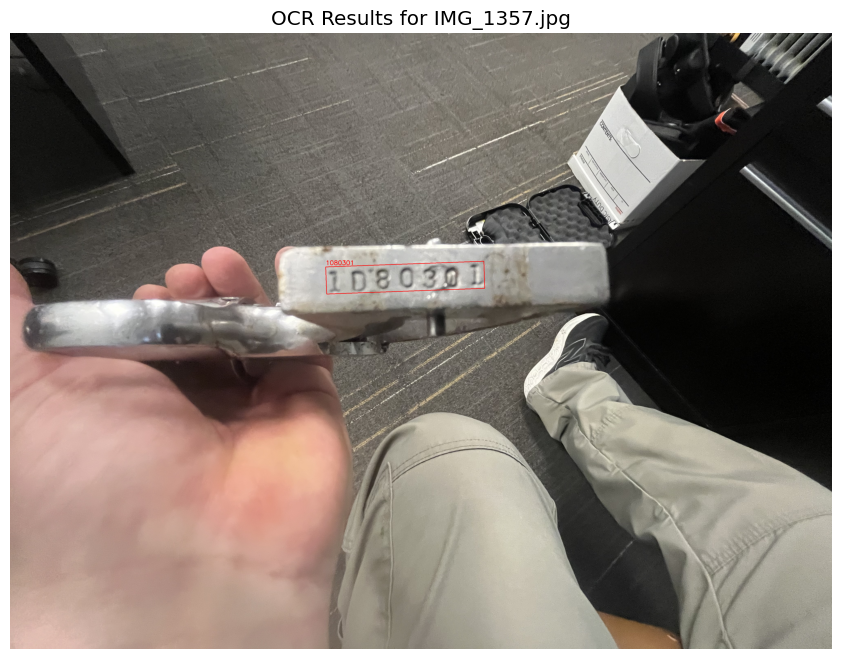


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED '1080301' (confidence: 1.070) from standard_ocr
      Original text: '1080301'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: 1080301
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: IMG_1357.jpg
  file_creation_date: 2025-08-04 03:57:31
  file_modification_date: 2025-08-04 03:57:31
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/IMG_1357.jpg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing: UPDATED FIREARM TRACKER.pdf
PDF file (would need special handling): UPDATED FIREARM TRACKER.pdf

Processing: IMG_5307.heic
Skipping non-image file: IMG_5307.heic

Processing: Frederuck, Darece Pistol License Front and Back.pdf
PDF fil

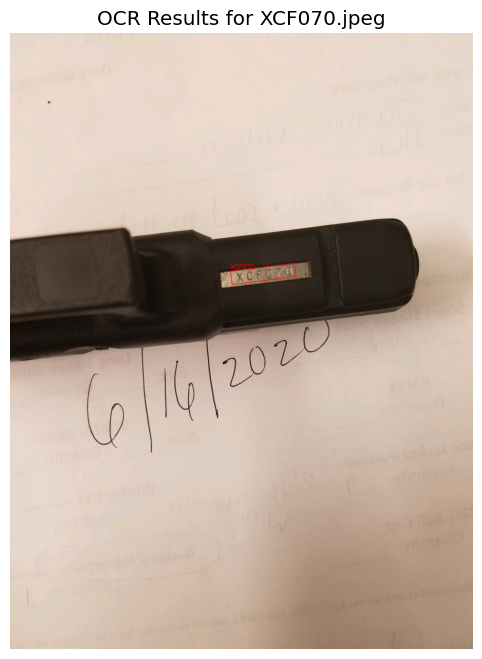


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED 'XCF070' (confidence: 1.077) from standard_ocr
      Original text: 'XCF070'
     '102030X' (confidence: 0.650) from preprocessed_morphological
      Original text: '102030X'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: XCF070
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: XCF070.jpeg
  file_creation_date: 2025-06-30 13:28:49
  file_modification_date: 2025-06-30 13:28:49
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/XCF070.jpeg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing: MUF408.jpg


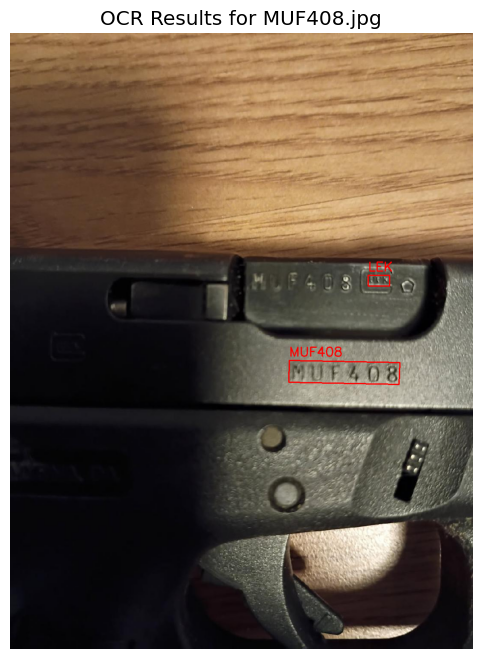


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED 'MUF408' (confidence: 1.161) from standard_ocr
      Original text: 'MUF408'
     'F403' (confidence: 0.964) from preprocessed_sharpened
      Original text: 'F403'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: MUF408
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: MUF408.jpg
  file_creation_date: 2025-06-30 13:28:47
  file_modification_date: 2025-06-30 13:28:47
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/MUF408.jpg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing complete!

NON-BMP IMAGE EXTRACTION RESULTS (CSV FORMAT)
serial_number,event_type,event_date,associated_name,associated_address,source_file,file_created,f

In [ ]:
# CELL 5: Process non-BMP image files with PaddleOCR (CPU-only) and CSV output

# Safe imports (ok to re-import in a notebook cell)
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import zipcodes

# PaddleOCR (CPU-only)
import paddle
from paddleocr import PaddleOCR

# Add metadata columns to df1
df1["filename"] = df1["filename"].astype(str)
df1["file_creation_date"] = df1["file_creation_date"].astype(str)
df1["file_modification_date"] = df1["file_modification_date"].astype(str)
df1["file_location"] = df1["file_location"].astype(str)

# Path to 'test' folder
test_folder = os.path.join(os.getcwd(), "test")

# Force CPU (current macOS wheels do not support 'mps')
try:
    paddle.set_device("cpu")
    print("Paddle set to CPU (MPS not available in this build).")
except Exception as e:
    print(f"Falling back to CPU due to error: {e}")
    paddle.set_device("cpu")

# Build PaddleOCR reader (avoid downscaling: large det_max_side_len)
ocr_reader = PaddleOCR(
    use_angle_cls=True,
    lang="en",
    det_max_side_len=4096,  # prevent unwanted downscaling on high-res images
    show_log=False,
)

# Get all files in 'test' folder (we'll still skip BMPs in the loop)
file_list = os.listdir(test_folder)

# Initialize CSV results list
csv_results = []

print(f"Found {len(file_list)} files in test folder")


def normalize_paddle_results(paddle_result):
    """
    Convert PaddleOCR result to a flat list of (bbox, text, confidence) like EasyOCR.
    Paddle format (for one image) is typically:
      [ [ [points, (text, conf)], [points, (text, conf)], ... ] ]
    or already a single list depending on version.
    """
    flat = []
    if not paddle_result:
        return flat

    # Handle both nested [list] and already-flat list cases
    if (
        isinstance(paddle_result, list)
        and len(paddle_result) > 0
        and isinstance(paddle_result[0], list)
        and len(paddle_result[0]) > 0
        and isinstance(paddle_result[0][0], (list, tuple))
        and len(paddle_result[0][0]) == 2
    ):
        candidates = paddle_result[0]
    else:
        candidates = paddle_result

    for item in candidates:
        # item is [points, (text, conf)]
        try:
            points, tc = item
            text, conf = tc
            # Normalize bbox as list of 4 points [[x1,y1],...]
            bbox = points
            flat.append((bbox, str(text), float(conf)))
        except Exception:
            # Be resilient if structure varies
            continue
    return flat


def paddle_readtext_cpu(image_or_path, **kwargs):
    """
    CPU-only OCR call wrapper (kept as a function for consistency).
    """
    return ocr_reader.ocr(image_or_path, **kwargs)


def extract_serial_with_improved_ocr(paddle_like_results, full_path):
    """Extract serial number focusing on OCR accuracy improvements"""

    def preprocess_image_for_ocr(image_path):
        """Apply image preprocessing to improve OCR accuracy"""
        import cv2
        import numpy as np

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply different preprocessing techniques
        preprocessed_images = []

        # Original grayscale
        preprocessed_images.append(("original_gray", gray))

        # Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        preprocessed_images.append(("blurred", blurred))

        # Sharpen
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(gray, -1, kernel)
        preprocessed_images.append(("sharpened", sharpened))

        # Adaptive threshold
        adaptive = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        preprocessed_images.append(("adaptive_thresh", adaptive))

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        morph = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel)
        preprocessed_images.append(("morphological", morph))

        return preprocessed_images

    def run_multiple_ocr_passes(image_path):
        """Run OCR with different parameters and preprocessing using PaddleOCR"""
        all_candidates = []

        # Standard OCR (on original)
        base_raw = paddle_readtext_cpu(image_path, cls=True)
        base = normalize_paddle_results(base_raw)
        for bbox, text, confidence in base:
            if text.strip() and confidence > 0.3:
                all_candidates.append(
                    {
                        "text": text.strip(),
                        "confidence": confidence,
                        "source": "standard_ocr",
                        "bbox": bbox,
                    }
                )

        # Try different preprocessing
        preprocessed_images = preprocess_image_for_ocr(image_path)
        if preprocessed_images:
            for prep_name, prep_img in preprocessed_images:
                try:
                    # PaddleOCR accepts np.ndarray as input
                    prep_raw = paddle_readtext_cpu(prep_img, cls=True)
                    prep_results = normalize_paddle_results(prep_raw)

                    for bbox, text, confidence in prep_results:
                        if (
                            text.strip() and confidence > 0.2
                        ):  # Lower threshold for preprocessed
                            all_candidates.append(
                                {
                                    "text": text.strip(),
                                    "confidence": confidence
                                    * 0.9,  # Slight penalty for preprocessed
                                    "source": f"preprocessed_{prep_name}",
                                    "bbox": bbox,
                                }
                            )
                except Exception as e:
                    print(f"Error with {prep_name} preprocessing: {e}")

        return all_candidates

    def find_potential_serials(candidates):
        """Find potential serial numbers from all OCR candidates"""
        potential_serials = []

        # Common words that are clearly NOT serial numbers
        non_serial_words = {
            "date",
            "city",
            "state",
            "name",
            "address",
            "phone",
            "email",
            "zip",
            "code",
            "serial",
            "number",
            "model",
            "make",
            "caliber",
            "type",
            "manufacturer",
            "license",
            "permit",
            "registration",
            "form",
            "page",
            "section",
            "dallas",
            "texas",
            "california",
            "florida",
            "new",
            "york",
            "smith",
            "wesson",
            "colt",
            "ruger",
            "glock",
            "sig",
            "sauer",
            "the",
            "and",
            "for",
            "with",
            "this",
            "that",
            "from",
            "have",
            "been",
            "firearm",
            "pistol",
            "rifle",
            "gun",
            "weapon",
            "barrel",
            "frame",
            "slide",
        }

        for candidate in candidates:
            text = candidate["text"]
            confidence = candidate["confidence"]
            source = candidate["source"]

            # Remove spaces and special characters
            cleaned = "".join(c for c in text if c.isalnum())

            # Skip if it's clearly not a serial number
            if cleaned.lower() in non_serial_words:
                continue

            # Skip if it's all letters and looks like a common word (likely not a serial)
            if cleaned.isalpha() and len(cleaned) <= 8:
                continue

            # Check if it could be a serial (basic length check)
            if 4 <= len(cleaned) <= 15 and cleaned.isalnum():
                # Additional check: prefer mixed alphanumeric or longer sequences
                has_letters = any(c.isalpha() for c in cleaned)
                has_numbers = any(c.isdigit() for c in cleaned)

                # Boost confidence for mixed alphanumeric (more likely to be serials)
                if has_letters and has_numbers:
                    confidence *= 1.2
                elif len(cleaned) >= 6:  # Or longer sequences
                    confidence *= 1.1

                potential_serials.append(
                    {
                        "serial": cleaned,
                        "original_text": text,
                        "confidence": confidence,
                        "source": source,
                        "bbox": candidate["bbox"],
                    }
                )

            # Also try spaced character reconstruction for this candidate
            if " " in text and len(text.split()) >= 3:
                parts = [p.strip() for p in text.split() if p.strip().isalnum()]
                if len(parts) >= 3:
                    reconstructed = "".join(parts)
                    if (
                        4 <= len(reconstructed) <= 15
                        and reconstructed.isalnum()
                        and reconstructed.lower() not in non_serial_words
                    ):
                        potential_serials.append(
                            {
                                "serial": reconstructed,
                                "original_text": text,
                                "confidence": confidence * 0.8,
                                "source": f"{source}_reconstructed",
                                "bbox": candidate["bbox"],
                            }
                        )

        return potential_serials

    # Run multiple OCR passes
    print("Running multiple OCR passes for improved accuracy...")
    all_candidates = run_multiple_ocr_passes(full_path)

    # Find potential serials
    potential_serials = find_potential_serials(all_candidates)

    # Remove duplicates and sort by confidence
    unique_serials = {}
    for serial_info in potential_serials:
        serial = serial_info["serial"]
        if (
            serial not in unique_serials
            or serial_info["confidence"] > unique_serials[serial]["confidence"]
        ):
            unique_serials[serial] = serial_info

    # Sort by confidence
    sorted_serials = sorted(
        unique_serials.values(), key=lambda x: x["confidence"], reverse=True
    )

    # Display top candidates for transparency
    print(f"\nSerial number candidates found:")
    if sorted_serials:
        for i, serial_info in enumerate(sorted_serials[:5]):  # Show top 5
            marker = "→ SELECTED" if i == 0 else "  "
            print(
                f"  {marker} '{serial_info['serial']}' (confidence: {serial_info['confidence']:.3f}) from {serial_info['source']}"
            )
            print(f"      Original text: '{serial_info['original_text']}'")
        return sorted_serials[0]["serial"]
    else:
        print("  No potential serial numbers found")
        return None


def extract_event_type_semantic(results):
    """
    Mirror BMP-style event detection with semantic priorities.
    Returns best event_type or None.
    """
    import re

    event_candidates = []

    # Excluded administrative words
    excluded_words = {
        "atf",
        "bureau",
        "federal",
        "department",
        "justice",
        "alcohol",
        "tobacco",
        "firearms",
        "explosives",
        "form",
        "section",
        "page",
        "number",
        "code",
        "licensee",
        "information",
        "details",
        "description",
        "brief",
        "name",
        "address",
        "telephone",
        "date",
        "time",
        "signature",
        "certification",
    }

    # Priority 1: Document purpose indicators
    purpose_patterns = [
        (
            r"(Theft|Loss|Stolen|Missing|Burglary|Robbery|Larceny).*?Report",
            "Theft/Loss",
        ),
        (r"Inventory\s+(Theft|Loss)", "Theft/Loss"),
        (
            r"(Purchase|Sale|Transfer|Registration|Acquisition|Disposition).*?Report",
            None,
        ),
    ]

    for pattern, fixed_event in purpose_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.4:
                event = fixed_event if fixed_event else m.group(1).title()
                event_candidates.append((event, conf + 1.0, "document_purpose", text))

    # Priority 2: Specific incident/crime types
    incident_types = {
        "burglary": "Burglary",
        "robbery": "Robbery",
        "larceny": "Larceny",
        "theft": "Theft",
        "stolen": "Theft",
        "missing": "Missing",
        "lost": "Loss",
    }
    for _, text, conf in results:
        text_clean = text.lower().strip()
        if text_clean in incident_types and conf > 0.5:
            event_candidates.append(
                (incident_types[text_clean], conf + 0.8, "incident_type", text)
            )

    # Priority 3: Action descriptions
    action_patterns = [
        (r"was\s+(stolen|taken|missing|lost)", None),
        (r"were\s+(stolen|taken|missing|lost)", None),
        (r"firearm\s+was\s+(\w+)", None),
        (r"gun\s+was\s+(\w+)", None),
    ]
    for pattern, _ in action_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.6:
                action = m.group(1).lower()
                if action in incident_types:
                    event_candidates.append(
                        (incident_types[action], conf + 0.6, "action_description", text)
                    )

    # Priority 4: Section headers
    section_patterns = [
        (r"(Theft|Loss|Stolen|Missing)\s+Information", None),
        (r"(Purchase|Sale|Transfer)\s+Information", None),
    ]
    for pattern, _ in section_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.6:
                event = m.group(1).title()
                if event.lower() not in excluded_words:
                    event_candidates.append((event, conf + 0.4, "section_header", text))

    # Priority 5: Meaningful single words
    for _, text, conf in results:
        t = text.strip()
        if len(t.split()) == 1 and len(t) > 3 and conf > 0.7 and t.isalpha():
            low = t.lower()
            if low not in excluded_words and low in incident_types:
                event_candidates.append(
                    (incident_types[low], conf + 0.2, "meaningful_word", text)
                )

    if not event_candidates:
        return None

    priority_order = {
        "document_purpose": 5,
        "incident_type": 4,
        "action_description": 3,
        "section_header": 2,
        "meaningful_word": 1,
    }
    event_candidates.sort(
        key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
    )
    return event_candidates[0][0]


for filename in file_list:
    full_path = os.path.join(test_folder, filename)

    # Skip if it's a folder
    if os.path.isdir(full_path):
        continue

    print(f"\nProcessing: {filename}")

    # Check if it's an image file (excluding BMP which is handled in another cell)
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".tiff", ".gif")):
        try:
            # PaddleOCR (CPU-only)
            paddle_raw = paddle_readtext_cpu(full_path, cls=True)
            results = normalize_paddle_results(
                paddle_raw
            )  # [(bbox, text, confidence), ...]

            # Place file in a DataFrame (kept for consistency/debugging)
            img_id = filename.split("/")[-1].split(".")[0]
            box_dataframe = pd.DataFrame(
                results, columns=["bbox", "text", "confidence"]
            )
            box_dataframe["img_id"] = img_id

            # Read image for visualization
            img = cv2.imread(full_path)

            # Display image with detected text if loaded successfully
            if img is not None and isinstance(img, np.ndarray):
                for bbox, text, confidence in results:
                    try:
                        pts = np.array(bbox, np.int32)
                        pts = pts.reshape((-1, 1, 2))
                        cv2.polylines(
                            img, [pts], isClosed=True, color=(0, 0, 255), thickness=2
                        )
                        x, y = pts[0][0]
                        cv2.putText(
                            img,
                            text,
                            (int(x), int(y) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (0, 0, 255),
                            2,
                        )
                    except Exception:
                        # be resilient to unexpected bbox formats
                        pass

                # Display the image
                try:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(12, 8))
                    plt.imshow(img_rgb)
                    plt.axis("off")
                    plt.title(f"OCR Results for {filename}")
                    plt.show()
                except Exception:
                    print(f"Warning: Could not display image {filename}")

            # OCR-focused serial extraction
            print("\n--- OCR-Focused Serial Number Detection ---")

            # Use OCR-focused extraction (reuses PaddleOCR under the hood)
            serial_num = extract_serial_with_improved_ocr(results, full_path)

            if not serial_num:
                print("No serial number found with OCR-focused extraction.")
                # Show all detected text for manual inspection
                if results:
                    print("All OCR detections:")
                    for i, (bbox, text, confidence) in enumerate(results):
                        print(f"  {i+1}. '{text}' (confidence: {confidence:.4f})")

            print("--- End OCR-Focused Serial Number Detection ---")

            # Extract other metadata
            matches = 0

            # Initialize variables to avoid NameError
            name = None
            addy = None
            date = None
            zipcode = None
            city = None
            state = None

            # Name extraction
            name_pat = r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b"
            for bbox, text, confidence in results:
                match = re.search(name_pat, text)
                if match and confidence > 0.8:
                    name = match.group()
                    matches += 1
                    break

            # Address extraction
            address_pat = r"\b\d{1,5}\s[A-Z][a-z]+\s[A-Z][a-z]+\b"
            for bbox, text, confidence in results:
                match = re.search(address_pat, text)
                if match:
                    addy = match.group()
                    matches += 1
                    break

            # Date extraction (support / and -)
            date_pat = r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b"
            for bbox, text, confidence in results:
                match = re.search(date_pat, text)
                if match:
                    date = match.group()
                    matches += 1
                    break

            # Event type extraction (semantic - mirrored from BMP logic)
            event_type = extract_event_type_semantic(results)
            if event_type:
                matches += 1
            else:
                event_type = None

            # Zipcode extraction
            zipcode_pat = r"\b\d{5}(-\d{4})?\b"
            if results:
                # Get image dimensions for targeted zipcode search
                try:
                    all_y_coords = [
                        point[1] for bbox, _, _ in results for point in bbox
                    ]
                    image_height = max(all_y_coords) if all_y_coords else 0
                except Exception:
                    image_height = 0

                # Target middle region for zipcodes
                top_boundary = image_height * 0.25
                bottom_boundary = image_height * 0.50

                # Find zipcode candidates
                candidates = []
                for bbox, text, confidence in results:
                    t = text.strip()
                    if re.match(zipcode_pat, t):
                        try:
                            top_y = min([point[1] for point in bbox])
                            bottom_y = max([point[1] for point in bbox])
                            text_center_y = (top_y + bottom_y) / 2
                        except Exception:
                            text_center_y = 0

                        if top_boundary <= text_center_y <= bottom_boundary:
                            candidates.append((t, confidence, text_center_y))

                if candidates:
                    # Return the candidate with highest confidence
                    best_candidate = max(candidates, key=lambda x: x[1])
                    zipcode = best_candidate[0]
                    matches += 1

            # Get city and state information from zipcode
            if zipcode:
                try:
                    end = zipcodes.matching(str(zipcode))
                    if end:
                        city = end[0]["city"]
                        state = end[0]["state"]
                        matches += 2
                except Exception as e:
                    print(f"Error looking up zipcode {zipcode}: {e}")

            # Get file metadata
            metadata = get_file_metadata(full_path)

            # Create relative path for source_file
            relative_path = os.path.join("test", filename)

            # Construct complete address
            complete_address = ""
            if addy:
                complete_address = addy
                if city and state:
                    complete_address += f", {city}, {state}"
                    if zipcode:
                        complete_address += f" {zipcode}"
                elif zipcode:
                    complete_address += f" {zipcode}"

            # Create CSV record with standardized columns, using 'Missing' for empty values
            csv_record = {
                "serial_number": str(serial_num) if serial_num else "Missing",
                "event_type": str(event_type) if event_type else "Missing",
                "event_date": str(date) if date else "Missing",
                "associated_name": str(name) if name else "Missing",
                "associated_address": (
                    str(complete_address) if complete_address else "Missing"
                ),
                "source_file": relative_path,
                "file_created": metadata["file_creation_date"],
                "file_modified": metadata["file_modification_date"],
            }

            csv_results.append(csv_record)

            # Add extracted information to df1 (legacy format)
            new_row = {
                "serial_number": str(serial_num) if serial_num else None,
                "name": str(name) if name else None,
                "address": str(addy) if addy else None,
                "date": str(date) if date else None,
                "zipcode": str(zipcode) if zipcode else None,
                "city": str(city) if city else None,
                "state": str(state) if state else None,
            }

            # Add the row
            df1 = pd.concat([df1, pd.DataFrame([new_row])], ignore_index=True)

            # Summary
            print("Summary...")
            print("Serial Number:", serial_num if serial_num else "Missing")
            print("Event Type:", event_type if event_type else "Missing")
            print("Name:", name if name else "Missing")
            print("Address:", complete_address if complete_address else "Missing")
            print("Date:", date if date else "Missing")
            print("Zipcode:", zipcode if zipcode else "Missing")
            print("City:", city if city else "Missing")
            print("State:", state if state else "Missing")
            print("Matches found:", matches, "/ 7")

            print("File Metadata:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")

            # Add metadata to df1 (legacy format)
            if serial_num:
                df1.loc[df1["serial_number"] == str(serial_num), "filename"] = metadata[
                    "filename"
                ]
                df1.loc[
                    df1["serial_number"] == str(serial_num), "file_creation_date"
                ] = metadata["file_creation_date"]
                df1.loc[
                    df1["serial_number"] == str(serial_num), "file_modification_date"
                ] = metadata["file_modification_date"]
                df1.loc[df1["serial_number"] == str(serial_num), "file_location"] = (
                    metadata["file_location"]
                )

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            import traceback

            traceback.print_exc()

    elif filename.lower().endswith(".bmp"):
        print(f"BMP file (handled in separate cell): {filename}")

    elif filename.lower().endswith(".pdf"):
        print(f"PDF file (would need special handling): {filename}")

    else:
        print(f"Skipping non-image file: {filename}")

print(f"\nProcessing complete!")

# Create and save CSV results to reports folder
if csv_results:
    results_df = pd.DataFrame(csv_results)
    print("\n" + "=" * 80)
    print("NON-BMP IMAGE EXTRACTION RESULTS (CSV FORMAT)")
    print("=" * 80)
    print(results_df.to_csv(index=False))

    # Create reports folder if it doesn't exist
    reports_folder = os.path.join(os.getcwd(), "reports")
    os.makedirs(reports_folder, exist_ok=True)

    # Save to file in reports folder
    output_file = os.path.join(reports_folder, "non_bmp_image_extraction_results.csv")
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
else:
    print("\nNo results to save.")


Paddle set to CPU (MPS not available in this build).
Found 11 files in test folder

Processing: 3310 BFMU971 fp.pdf
PDF file (would need special handling): 3310 BFMU971 fp.pdf

Processing: .DS_Store
Skipping non-image file: .DS_Store

Processing: BSPB295.pdf
PDF file (would need special handling): BSPB295.pdf

Processing: IMG_1357.jpg


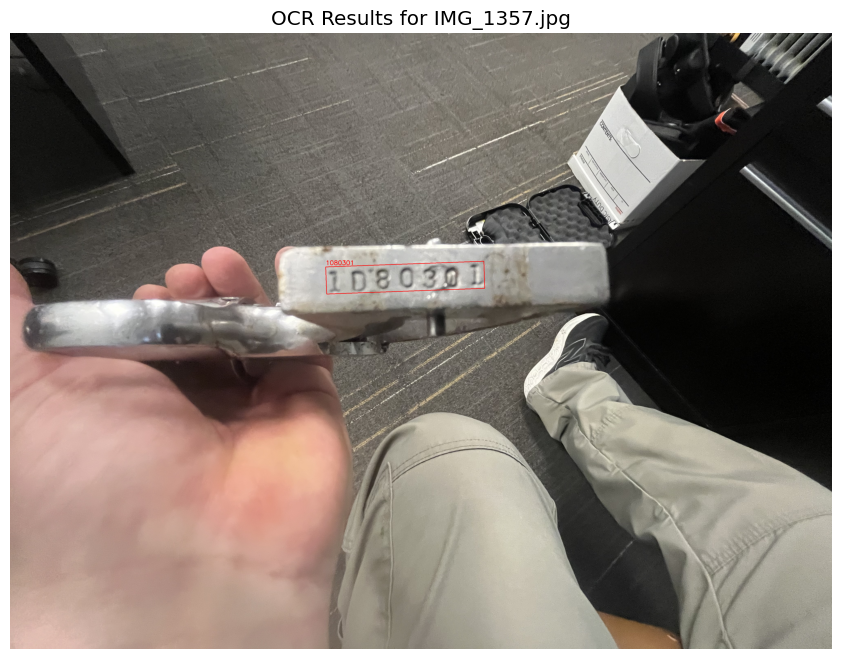


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED '1080301' (confidence: 1.070) from standard_ocr
      Original text: '1080301'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: 1080301
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: IMG_1357.jpg
  file_creation_date: 2025-08-04 03:57:31
  file_modification_date: 2025-08-04 03:57:31
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/IMG_1357.jpg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing: UPDATED FIREARM TRACKER.pdf
PDF file (would need special handling): UPDATED FIREARM TRACKER.pdf

Processing: IMG_5307.heic
Skipping non-image file: IMG_5307.heic

Processing: Frederuck, Darece Pistol License Front and Back.pdf
PDF fil

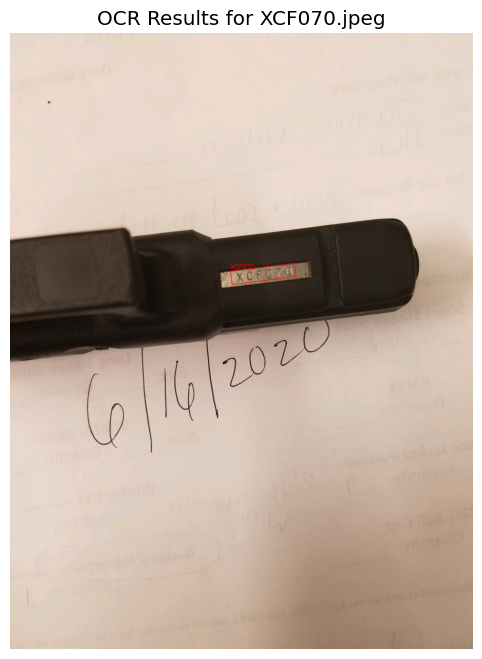


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED 'XCF070' (confidence: 1.077) from standard_ocr
      Original text: 'XCF070'
     '102030X' (confidence: 0.650) from preprocessed_morphological
      Original text: '102030X'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: XCF070
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: XCF070.jpeg
  file_creation_date: 2025-06-30 13:28:49
  file_modification_date: 2025-06-30 13:28:49
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/XCF070.jpeg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing: MUF408.jpg


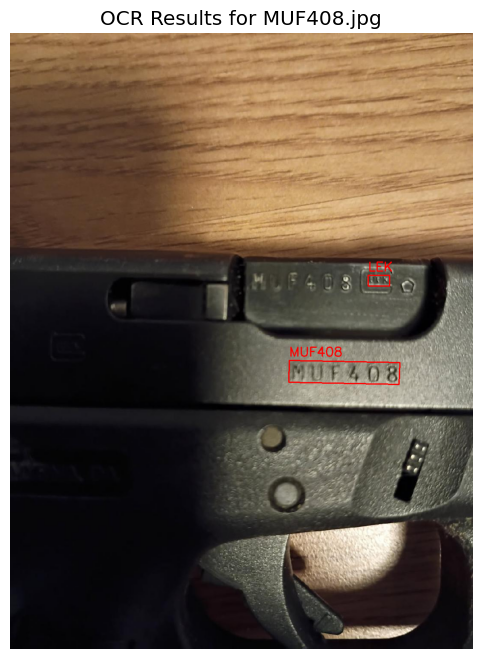


--- OCR-Focused Serial Number Detection ---
Running multiple OCR passes for improved accuracy...

Serial number candidates found:
  → SELECTED 'MUF408' (confidence: 1.161) from standard_ocr
      Original text: 'MUF408'
     'F403' (confidence: 0.964) from preprocessed_sharpened
      Original text: 'F403'
--- End OCR-Focused Serial Number Detection ---
Summary...
Serial Number: MUF408
Event Type: Missing
Name: Missing
Address: Missing
Date: Missing
Zipcode: Missing
City: Missing
State: Missing
Matches found: 0 / 7
File Metadata:
  filename: MUF408.jpg
  file_creation_date: 2025-06-30 13:28:47
  file_modification_date: 2025-06-30 13:28:47
  file_location: /Users/nikolay_tishchenko/Projects/codeium/allied/test/MUF408.jpg
  platform: darwin
  creation_source: st_birthtime (macOS/BSD creation time)
  creation_reliable: True

Processing complete!

NON-BMP IMAGE EXTRACTION RESULTS (CSV FORMAT)
serial_number,event_type,event_date,associated_name,associated_address,source_file,file_created,f

In [ ]:
# CELL 6: Process non-BMP image files with PaddleOCR (CPU-only) and CSV output

# Safe imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import zipcodes

# PaddleOCR (CPU-only)
try:
    import paddle
    from paddleocr import PaddleOCR
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "Paddle not available in this kernel. Install with:\n"
        "  pip install paddlepaddle==2.6.1 'paddleocr>=2.7'\n"
        "or switch to your Python 3.11 env where Paddle is installed."
    ) from e

# Add metadata columns to df1
df1["filename"] = df1["filename"].astype(str)
df1["file_creation_date"] = df1["file_creation_date"].astype(str)
df1["file_modification_date"] = df1["file_modification_date"].astype(str)
df1["file_location"] = df1["file_location"].astype(str)

# Path to 'test' folder
test_folder = os.path.join(os.getcwd(), "test")

# Force CPU (current macOS wheels do not support 'mps')
try:
    paddle.set_device("cpu")
    print("Paddle set to CPU (MPS not available in this build).")
except Exception as e:
    print(f"Falling back to CPU due to error: {e}")
    paddle.set_device("cpu")

# Build PaddleOCR reader (avoid downscaling: large det_max_side_len)
ocr_reader = PaddleOCR(
    use_angle_cls=True,
    lang="en",
    det_max_side_len=4096,  # prevent unwanted downscaling on high-res images
    show_log=False,
)

# Get all files in 'test' folder (we'll still skip BMPs in the loop)
file_list = os.listdir(test_folder)

# Initialize CSV results list
csv_results = []

print(f"Found {len(file_list)} files in test folder")


def normalize_paddle_results(paddle_result):
    """
    Convert PaddleOCR result to a flat list of (bbox, text, confidence) like EasyOCR.
    Paddle format (for one image) is typically:
      [ [ [points, (text, conf)], [points, (text, conf)], ... ] ]
    or already a single list depending on version.
    """
    flat = []
    if not paddle_result:
        return flat

    # Handle both nested [list] and already-flat list cases
    if (
        isinstance(paddle_result, list)
        and len(paddle_result) > 0
        and isinstance(paddle_result[0], list)
        and len(paddle_result[0]) > 0
        and isinstance(paddle_result[0][0], (list, tuple))
        and len(paddle_result[0][0]) == 2
    ):
        candidates = paddle_result[0]
    else:
        candidates = paddle_result

    for item in candidates:
        # item is [points, (text, conf)]
        try:
            points, tc = item
            text, conf = tc
            # Normalize bbox as list of 4 points [[x1,y1],...]
            bbox = points
            flat.append((bbox, str(text), float(conf)))
        except Exception:
            # Be resilient if structure varies
            continue
    return flat


def paddle_readtext_cpu(image_or_path, **kwargs):
    """
    CPU-only OCR call wrapper (kept as a function for consistency).
    """
    return ocr_reader.ocr(image_or_path, **kwargs)


def extract_serial_with_improved_ocr(paddle_like_results, full_path):
    """Extract serial number focusing on OCR accuracy improvements"""

    def preprocess_image_for_ocr(image_path):
        """Apply image preprocessing to improve OCR accuracy"""
        import cv2
        import numpy as np

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply different preprocessing techniques
        preprocessed_images = []

        # Original grayscale
        preprocessed_images.append(("original_gray", gray))

        # Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        preprocessed_images.append(("blurred", blurred))

        # Sharpen
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(gray, -1, kernel)
        preprocessed_images.append(("sharpened", sharpened))

        # Adaptive threshold
        adaptive = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        preprocessed_images.append(("adaptive_thresh", adaptive))

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        morph = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel)
        preprocessed_images.append(("morphological", morph))

        return preprocessed_images

    def run_multiple_ocr_passes(image_path):
        """Run OCR with different parameters and preprocessing using PaddleOCR"""
        all_candidates = []

        # Standard OCR (on original)
        base_raw = paddle_readtext_cpu(image_path, cls=True)
        base = normalize_paddle_results(base_raw)
        for bbox, text, confidence in base:
            if text.strip() and confidence > 0.3:
                all_candidates.append(
                    {
                        "text": text.strip(),
                        "confidence": confidence,
                        "source": "standard_ocr",
                        "bbox": bbox,
                    }
                )

        # Try different preprocessing
        preprocessed_images = preprocess_image_for_ocr(image_path)
        if preprocessed_images:
            for prep_name, prep_img in preprocessed_images:
                try:
                    # PaddleOCR accepts np.ndarray as input
                    prep_raw = paddle_readtext_cpu(prep_img, cls=True)
                    prep_results = normalize_paddle_results(prep_raw)

                    for bbox, text, confidence in prep_results:
                        if (
                            text.strip() and confidence > 0.2
                        ):  # Lower threshold for preprocessed
                            all_candidates.append(
                                {
                                    "text": text.strip(),
                                    "confidence": confidence
                                    * 0.9,  # Slight penalty for preprocessed
                                    "source": f"preprocessed_{prep_name}",
                                    "bbox": bbox,
                                }
                            )
                except Exception as e:
                    print(f"Error with {prep_name} preprocessing: {e}")

        return all_candidates

    def find_potential_serials(candidates):
        """Find potential serial numbers from all OCR candidates"""
        potential_serials = []

        # Common words that are clearly NOT serial numbers
        non_serial_words = {
            "date",
            "city",
            "state",
            "name",
            "address",
            "phone",
            "email",
            "zip",
            "code",
            "serial",
            "number",
            "model",
            "make",
            "caliber",
            "type",
            "manufacturer",
            "license",
            "permit",
            "registration",
            "form",
            "page",
            "section",
            "dallas",
            "texas",
            "california",
            "florida",
            "new",
            "york",
            "smith",
            "wesson",
            "colt",
            "ruger",
            "glock",
            "sig",
            "sauer",
            "the",
            "and",
            "for",
            "with",
            "this",
            "that",
            "from",
            "have",
            "been",
            "firearm",
            "pistol",
            "rifle",
            "gun",
            "weapon",
            "barrel",
            "frame",
            "slide",
        }

        for candidate in candidates:
            text = candidate["text"]
            confidence = candidate["confidence"]
            source = candidate["source"]

            # Remove spaces and special characters
            cleaned = "".join(c for c in text if c.isalnum())

            # Skip if it's clearly not a serial number
            if cleaned.lower() in non_serial_words:
                continue

            # Skip if it's all letters and looks like a common word (likely not a serial)
            if cleaned.isalpha() and len(cleaned) <= 8:
                continue

            # Check if it could be a serial (basic length check)
            if 4 <= len(cleaned) <= 15 and cleaned.isalnum():
                # Additional check: prefer mixed alphanumeric or longer sequences
                has_letters = any(c.isalpha() for c in cleaned)
                has_numbers = any(c.isdigit() for c in cleaned)

                # Boost confidence for mixed alphanumeric (more likely to be serials)
                if has_letters and has_numbers:
                    confidence *= 1.2
                elif len(cleaned) >= 6:  # Or longer sequences
                    confidence *= 1.1

                potential_serials.append(
                    {
                        "serial": cleaned,
                        "original_text": text,
                        "confidence": confidence,
                        "source": source,
                        "bbox": candidate["bbox"],
                    }
                )

            # Also try spaced character reconstruction for this candidate
            if " " in text and len(text.split()) >= 3:
                parts = [p.strip() for p in text.split() if p.strip().isalnum()]
                if len(parts) >= 3:
                    reconstructed = "".join(parts)
                    if (
                        4 <= len(reconstructed) <= 15
                        and reconstructed.isalnum()
                        and reconstructed.lower() not in non_serial_words
                    ):
                        potential_serials.append(
                            {
                                "serial": reconstructed,
                                "original_text": text,
                                "confidence": confidence * 0.8,
                                "source": f"{source}_reconstructed",
                                "bbox": candidate["bbox"],
                            }
                        )

        return potential_serials

    # Run multiple OCR passes
    print("Running multiple OCR passes for improved accuracy...")
    all_candidates = run_multiple_ocr_passes(full_path)

    # Find potential serials
    potential_serials = find_potential_serials(all_candidates)

    # Remove duplicates and sort by confidence
    unique_serials = {}
    for serial_info in potential_serials:
        serial = serial_info["serial"]
        if (
            serial not in unique_serials
            or serial_info["confidence"] > unique_serials[serial]["confidence"]
        ):
            unique_serials[serial] = serial_info

    # Sort by confidence
    sorted_serials = sorted(
        unique_serials.values(), key=lambda x: x["confidence"], reverse=True
    )

    # Display top candidates for transparency
    print(f"\nSerial number candidates found:")
    if sorted_serials:
        for i, serial_info in enumerate(sorted_serials[:5]):  # Show top 5
            marker = "→ SELECTED" if i == 0 else "  "
            print(
                f"  {marker} '{serial_info['serial']}' (confidence: {serial_info['confidence']:.3f}) from {serial_info['source']}"
            )
            print(f"      Original text: '{serial_info['original_text']}'")
        return sorted_serials[0]["serial"]
    else:
        print("  No potential serial numbers found")
        return None


def extract_event_type_semantic(results):
    """
    Mirror BMP-style event detection with semantic priorities.
    Returns best event_type or None.
    """
    import re

    event_candidates = []

    # Excluded administrative words
    excluded_words = {
        "atf",
        "bureau",
        "federal",
        "department",
        "justice",
        "alcohol",
        "tobacco",
        "firearms",
        "explosives",
        "form",
        "section",
        "page",
        "number",
        "code",
        "licensee",
        "information",
        "details",
        "description",
        "brief",
        "name",
        "address",
        "telephone",
        "date",
        "time",
        "signature",
        "certification",
    }

    # Priority 1: Document purpose indicators
    purpose_patterns = [
        (
            r"(Theft|Loss|Stolen|Missing|Burglary|Robbery|Larceny).*?Report",
            "Theft/Loss",
        ),
        (r"Inventory\s+(Theft|Loss)", "Theft/Loss"),
        (
            r"(Purchase|Sale|Transfer|Registration|Acquisition|Disposition).*?Report",
            None,
        ),
    ]

    for pattern, fixed_event in purpose_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.4:
                event = fixed_event if fixed_event else m.group(1).title()
                event_candidates.append((event, conf + 1.0, "document_purpose", text))

    # Priority 2: Specific incident/crime types
    incident_types = {
        "burglary": "Burglary",
        "robbery": "Robbery",
        "larceny": "Larceny",
        "theft": "Theft",
        "stolen": "Theft",
        "missing": "Missing",
        "lost": "Loss",
    }
    for _, text, conf in results:
        text_clean = text.lower().strip()
        if text_clean in incident_types and conf > 0.5:
            event_candidates.append(
                (incident_types[text_clean], conf + 0.8, "incident_type", text)
            )

    # Priority 3: Action descriptions
    action_patterns = [
        (r"was\s+(stolen|taken|missing|lost)", None),
        (r"were\s+(stolen|taken|missing|lost)", None),
        (r"firearm\s+was\s+(\w+)", None),
        (r"gun\s+was\s+(\w+)", None),
    ]
    for pattern, _ in action_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.6:
                action = m.group(1).lower()
                if action in incident_types:
                    event_candidates.append(
                        (incident_types[action], conf + 0.6, "action_description", text)
                    )

    # Priority 4: Section headers
    section_patterns = [
        (r"(Theft|Loss|Stolen|Missing)\s+Information", None),
        (r"(Purchase|Sale|Transfer)\s+Information", None),
    ]
    for pattern, _ in section_patterns:
        for _, text, conf in results:
            m = re.search(pattern, text, re.IGNORECASE)
            if m and conf > 0.6:
                event = m.group(1).title()
                if event.lower() not in excluded_words:
                    event_candidates.append((event, conf + 0.4, "section_header", text))

    # Priority 5: Meaningful single words
    for _, text, conf in results:
        t = text.strip()
        if len(t.split()) == 1 and len(t) > 3 and conf > 0.7 and t.isalpha():
            low = t.lower()
            if low not in excluded_words and low in incident_types:
                event_candidates.append(
                    (incident_types[low], conf + 0.2, "meaningful_word", text)
                )

    if not event_candidates:
        return None

    priority_order = {
        "document_purpose": 5,
        "incident_type": 4,
        "action_description": 3,
        "section_header": 2,
        "meaningful_word": 1,
    }
    event_candidates.sort(
        key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
    )
    return event_candidates[0][0]


for filename in file_list:
    full_path = os.path.join(test_folder, filename)

    # Skip if it's a folder
    if os.path.isdir(full_path):
        continue

    print(f"\nProcessing: {filename}")

    # Check if it's an image file (excluding BMP which is handled in another cell)
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".tiff", ".gif")):
        try:
            # PaddleOCR (CPU-only)
            paddle_raw = paddle_readtext_cpu(full_path, cls=True)
            results = normalize_paddle_results(
                paddle_raw
            )  # [(bbox, text, confidence), ...]

            # Place file in a DataFrame (kept for consistency/debugging)
            img_id = filename.split("/")[-1].split(".")[0]
            box_dataframe = pd.DataFrame(
                results, columns=["bbox", "text", "confidence"]
            )
            box_dataframe["img_id"] = img_id

            # Read image for visualization
            img = cv2.imread(full_path)

            # Display image with detected text if loaded successfully
            if img is not None and isinstance(img, np.ndarray):
                for bbox, text, confidence in results:
                    try:
                        pts = np.array(bbox, np.int32)
                        pts = pts.reshape((-1, 1, 2))
                        cv2.polylines(
                            img, [pts], isClosed=True, color=(0, 0, 255), thickness=2
                        )
                        x, y = pts[0][0]
                        cv2.putText(
                            img,
                            text,
                            (int(x), int(y) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (0, 0, 255),
                            2,
                        )
                    except Exception:
                        # be resilient to unexpected bbox formats
                        pass

                # Display the image
                try:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(12, 8))
                    plt.imshow(img_rgb)
                    plt.axis("off")
                    plt.title(f"OCR Results for {filename}")
                    plt.show()
                except Exception:
                    print(f"Warning: Could not display image {filename}")

            # OCR-focused serial extraction
            print("\n--- OCR-Focused Serial Number Detection ---")

            # Use OCR-focused extraction (reuses PaddleOCR under the hood)
            serial_num = extract_serial_with_improved_ocr(results, full_path)

            if not serial_num:
                print("No serial number found with OCR-focused extraction.")
                # Show all detected text for manual inspection
                if results:
                    print("All OCR detections:")
                    for i, (bbox, text, confidence) in enumerate(results):
                        print(f"  {i+1}. '{text}' (confidence: {confidence:.4f})")

            print("--- End OCR-Focused Serial Number Detection ---")

            # Extract other metadata
            matches = 0

            # Initialize variables to avoid NameError
            name = None
            addy = None
            date = None
            zipcode = None
            city = None
            state = None

            # Name extraction
            name_pat = r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b"
            for bbox, text, confidence in results:
                match = re.search(name_pat, text)
                if match and confidence > 0.8:
                    name = match.group()
                    matches += 1
                    break

            # Address extraction
            address_pat = r"\b\d{1,5}\s[A-Z][a-z]+\s[A-Z][a-z]+\b"
            for bbox, text, confidence in results:
                match = re.search(address_pat, text)
                if match:
                    addy = match.group()
                    matches += 1
                    break

            # Date extraction (support / and -)
            date_pat = r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b"
            for bbox, text, confidence in results:
                match = re.search(date_pat, text)
                if match:
                    date = match.group()
                    matches += 1
                    break

            # Event type extraction (semantic - mirrored from BMP logic)
            event_type = extract_event_type_semantic(results)
            if event_type:
                matches += 1
            else:
                event_type = None

            # Zipcode extraction
            zipcode_pat = r"\b\d{5}(-\d{4})?\b"
            if results:
                # Get image dimensions for targeted zipcode search
                try:
                    all_y_coords = [
                        point[1] for bbox, _, _ in results for point in bbox
                    ]
                    image_height = max(all_y_coords) if all_y_coords else 0
                except Exception:
                    image_height = 0

                # Target middle region for zipcodes
                top_boundary = image_height * 0.25
                bottom_boundary = image_height * 0.50

                # Find zipcode candidates
                candidates = []
                for bbox, text, confidence in results:
                    t = text.strip()
                    if re.match(zipcode_pat, t):
                        try:
                            top_y = min([point[1] for point in bbox])
                            bottom_y = max([point[1] for point in bbox])
                            text_center_y = (top_y + bottom_y) / 2
                        except Exception:
                            text_center_y = 0

                        if top_boundary <= text_center_y <= bottom_boundary:
                            candidates.append((t, confidence, text_center_y))

                if candidates:
                    # Return the candidate with highest confidence
                    best_candidate = max(candidates, key=lambda x: x[1])
                    zipcode = best_candidate[0]
                    matches += 1

            # Get city and state information from zipcode
            if zipcode:
                try:
                    end = zipcodes.matching(str(zipcode))
                    if end:
                        city = end[0]["city"]
                        state = end[0]["state"]
                        matches += 2
                except Exception as e:
                    print(f"Error looking up zipcode {zipcode}: {e}")

            # Get file metadata
            metadata = get_file_metadata(full_path)

            # Create relative path for source_file
            relative_path = os.path.join("test", filename)

            # Construct complete address
            complete_address = ""
            if addy:
                complete_address = addy
                if city and state:
                    complete_address += f", {city}, {state}"
                    if zipcode:
                        complete_address += f" {zipcode}"
                elif zipcode:
                    complete_address += f" {zipcode}"

            # Create CSV record with standardized columns, using 'Missing' for empty values
            csv_record = {
                "serial_number": str(serial_num) if serial_num else "Missing",
                "event_type": str(event_type) if event_type else "Missing",
                "event_date": str(date) if date else "Missing",
                "associated_name": str(name) if name else "Missing",
                "associated_address": (
                    str(complete_address) if complete_address else "Missing"
                ),
                "source_file": relative_path,
                "file_created": metadata["file_creation_date"],
                "file_modified": metadata["file_modification_date"],
            }

            csv_results.append(csv_record)

            # Add extracted information to df1 (legacy format)
            new_row = {
                "serial_number": str(serial_num) if serial_num else None,
                "name": str(name) if name else None,
                "address": str(addy) if addy else None,
                "date": str(date) if date else None,
                "zipcode": str(zipcode) if zipcode else None,
                "city": str(city) if city else None,
                "state": str(state) if state else None,
            }

            # Add the row
            df1 = pd.concat([df1, pd.DataFrame([new_row])], ignore_index=True)

            # Summary
            print("Summary...")
            print("Serial Number:", serial_num if serial_num else "Missing")
            print("Event Type:", event_type if event_type else "Missing")
            print("Name:", name if name else "Missing")
            print("Address:", complete_address if complete_address else "Missing")
            print("Date:", date if date else "Missing")
            print("Zipcode:", zipcode if zipcode else "Missing")
            print("City:", city if city else "Missing")
            print("State:", state if state else "Missing")
            print("Matches found:", matches, "/ 7")

            print("File Metadata:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")

            # Add metadata to df1 (legacy format)
            if serial_num:
                df1.loc[df1["serial_number"] == str(serial_num), "filename"] = metadata[
                    "filename"
                ]
                df1.loc[
                    df1["serial_number"] == str(serial_num), "file_creation_date"
                ] = metadata["file_creation_date"]
                df1.loc[
                    df1["serial_number"] == str(serial_num), "file_modification_date"
                ] = metadata["file_modification_date"]
                df1.loc[df1["serial_number"] == str(serial_num), "file_location"] = (
                    metadata["file_location"]
                )

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            import traceback

            traceback.print_exc()

    elif filename.lower().endswith(".bmp"):
        print(f"BMP file (handled in separate cell): {filename}")

    elif filename.lower().endswith(".pdf"):
        print(f"PDF file (would need special handling): {filename}")

    else:
        print(f"Skipping non-image file: {filename}")

print(f"\nProcessing complete!")

# Create and save CSV results to reports folder
if csv_results:
    results_df = pd.DataFrame(csv_results)
    print("\n" + "=" * 80)
    print("NON-BMP IMAGE EXTRACTION RESULTS (CSV FORMAT)")
    print("=" * 80)
    print(results_df.to_csv(index=False))

    # Create reports folder if it doesn't exist
    reports_folder = os.path.join(os.getcwd(), "reports")
    os.makedirs(reports_folder, exist_ok=True)

    # Save to file in reports folder
    output_file = os.path.join(reports_folder, "non_bmp_image_extraction_results.csv")
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
else:
    print("\nNo results to save.")


In [ ]:
# CELL 7: Build Full Image Extraction Report with All Available Fields

import os
import pandas as pd
from IPython.display import display

# Ensure df1 exists
try:
    df1  # noqa: F821
except NameError:
    raise RuntimeError("df1 is not defined earlier in the notebook.")

ROOT = os.getcwd()


def _to_rel(p: str) -> str:
    if isinstance(p, str) and p:
        try:
            return os.path.relpath(p, ROOT)
        except Exception:
            return os.path.basename(p)
    return p


def _normalize_source_file(s: str) -> str:
    if isinstance(s, str) and s:
        try:
            return os.path.relpath(s, ROOT) if os.path.isabs(s) else s
        except Exception:
            return os.path.basename(s)
    return s


def _blank_mask(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    return series.isna() | s.str.strip().isin(["", "None", "nan", "NaT"])


def _is_blank_val(v) -> bool:
    if v is None:
        return True
    try:
        if pd.isna(v):
            return True
    except Exception:
        pass
    return isinstance(v, str) and v.strip() in ("", "None", "nan", "NaT")


# 1) Standardize / backfill unified semantic columns
# event_type <= event_name
if "event_type" not in df1.columns:
    df1["event_type"] = None
if "event_name" in df1.columns:
    mask = _blank_mask(df1["event_type"])
    df1.loc[mask, "event_type"] = df1.loc[mask, "event_name"]

# event_date <= date
if "event_date" not in df1.columns:
    df1["event_date"] = None
if "date" in df1.columns:
    mask = _blank_mask(df1["event_date"])
    df1.loc[mask, "event_date"] = df1.loc[mask, "date"]

# associated_name <= name
if "associated_name" not in df1.columns:
    df1["associated_name"] = None
if "name" in df1.columns:
    mask = _blank_mask(df1["associated_name"])
    df1.loc[mask, "associated_name"] = df1.loc[mask, "name"]

# Prepare address components
for col in ["associated_address", "address"]:
    if col not in df1.columns:
        df1[col] = None
for col in ["city", "state", "zipcode"]:
    if col not in df1.columns:
        df1[col] = None


# Build full associated_address = "<street>, <City>, <State> <Zip>"
def _compose_full_address(row) -> str | None:
    # Prefer an existing complete address if present
    ca = row.get("complete_address") if "complete_address" in row else None
    if isinstance(ca, str) and ca.strip():
        return ca.strip()

    street = row.get("associated_address")
    if _is_blank_val(street):
        street = row.get("address")

    city = row.get("city")
    state = row.get("state")
    zipcode = row.get("zipcode")

    has_street = not _is_blank_val(street)
    has_city = not _is_blank_val(city)
    has_state = not _is_blank_val(state)
    has_zip = not _is_blank_val(zipcode)

    if not any([has_street, has_city, has_state, has_zip]):
        return None

    parts = []
    if has_street:
        parts.append(str(street).strip())

    loc = []
    if has_city:
        loc.append(str(city).strip())
    if has_state:
        loc.append(str(state).strip())

    loc_str = ", ".join(loc) if loc else ""
    if loc_str:
        if parts:
            parts[-1] = f"{parts[-1]}, {loc_str}"
        else:
            parts.append(loc_str)

    if has_zip:
        if parts:
            parts[-1] = f"{parts[-1]} {str(zipcode).strip()}"
        else:
            parts.append(str(zipcode).strip())

    return parts[0] if parts else None


df1["associated_address"] = df1.apply(_compose_full_address, axis=1)

# file_created/modified <= file_creation_date/modification_date (keep only file_created/file_modified in report)
if "file_created" not in df1.columns:
    df1["file_created"] = None
if "file_creation_date" in df1.columns:
    mask = _blank_mask(df1["file_created"])
    df1.loc[mask, "file_created"] = df1.loc[mask, "file_creation_date"]

if "file_modified" not in df1.columns:
    df1["file_modified"] = None
if "file_modification_date" in df1.columns:
    mask = _blank_mask(df1["file_modified"])
    df1.loc[mask, "file_modified"] = df1.loc[mask, "file_modification_date"]

# Create/normalize source_file (prefer file_location relative; else infer from filename)
if "source_file" not in df1.columns:
    df1["source_file"] = None

if "file_location" in df1.columns:
    mask = _blank_mask(df1["source_file"])
    df1.loc[mask, "source_file"] = df1.loc[mask, "file_location"].apply(_to_rel)

if "filename" in df1.columns:
    mask = _blank_mask(df1["source_file"])
    df1.loc[mask, "source_file"] = df1.loc[mask, "filename"].apply(
        lambda n: os.path.join("test", n) if isinstance(n, str) and n else n
    )

df1["source_file"] = df1["source_file"].apply(_normalize_source_file)

# 2) Augment with metadata fields (platform, creation_source, creation_reliable)
for col in ["platform", "creation_source", "creation_reliable"]:
    if col not in df1.columns:
        df1[col] = None

# Populate metadata by re-calling get_file_metadata where missing
if "file_location" in df1.columns:

    def _augment_row(row):
        need_meta = (
            _is_blank_val(row.get("platform"))
            or _is_blank_val(row.get("creation_source"))
            or _is_blank_val(row.get("creation_reliable"))
        )
        loc = row.get("file_location")
        cand = None
        if isinstance(loc, str) and loc:
            cand = loc if os.path.isabs(loc) else os.path.join(ROOT, loc)
        if need_meta and isinstance(cand, str) and os.path.exists(cand):
            try:
                md = get_file_metadata(cand)  # from Cell 2
                row["platform"] = (
                    row.get("platform")
                    if not _is_blank_val(row.get("platform"))
                    else md.get("platform")
                )
                row["creation_source"] = (
                    row.get("creation_source")
                    if not _is_blank_val(row.get("creation_source"))
                    else md.get("creation_source")
                )
                row["creation_reliable"] = (
                    row.get("creation_reliable")
                    if not _is_blank_val(row.get("creation_reliable"))
                    else md.get("creation_reliable")
                )
                if _is_blank_val(row.get("file_created")):
                    row["file_created"] = md.get("file_creation_date")
                if _is_blank_val(row.get("file_modified")):
                    row["file_modified"] = md.get("file_modification_date")
            except Exception:
                pass
        return row

    df1 = df1.apply(_augment_row, axis=1)

# Normalize file_location for report view to relative (if present)
if "file_location" in df1.columns:
    df1["file_location"] = df1["file_location"].apply(_to_rel)

# 3) Deduplicate (serial_number + source_file)
if {"serial_number", "source_file"}.issubset(df1.columns):
    before = len(df1)
    df1 = df1.drop_duplicates(subset=["serial_number", "source_file"], keep="first")
    after = len(df1)
    if before != after:
        print(
            f"Deduplicated rows: {before - after} removed (serial_number + source_file)."
        )

# 4) Final report column order (suppress duplicate/legacy columns)
preferred_order = [
    "serial_number",
    "event_type",
    "event_date",
    "associated_name",
    "associated_address",
    "source_file",  # keep only this (drop filename)
    "file_created",  # keep only this (drop file_creation_date)
    "file_modified",  # keep only this (drop file_modification_date)
    "file_location",
    "platform",
    "creation_source",
    "creation_reliable",
]
# Exclude legacy/duplicate columns:
# - date/name/address/event_name/complete_address are legacy inputs
# - zipcode/city/state are now part of associated_address
# - filename duplicates source_file
# - file_creation_date/file_modification_date duplicate file_created/file_modified
suppress_cols = {
    "date",
    "name",
    "address",
    "event_name",
    "complete_address",
    "zipcode",
    "city",
    "state",
    "filename",
    "file_creation_date",
    "file_modification_date",
}
extra_cols = [
    c for c in df1.columns if c not in preferred_order and c not in suppress_cols
]
final_cols = [c for c in preferred_order if c in df1.columns] + extra_cols

report_df = df1[final_cols].copy()

# 5) Output
reports_folder = os.path.join(os.getcwd(), "reports")
os.makedirs(reports_folder, exist_ok=True)
report_path = os.path.join(reports_folder, "full_image_extraction_report.csv")
report_df.to_csv(report_path, index=False)

print(f"Full report written: {report_path}")
print(f"Rows: {len(report_df)} | Columns: {len(report_df.columns)}")
print("Columns order:")
print(final_cols)

display(report_df.head(10))


Deduplicated rows: 3 removed (serial_number + source_file).
Full report written: /Users/nikolay_tishchenko/Projects/codeium/allied/reports/full_image_extraction_report.csv
Rows: 4 | Columns: 12
Columns order:
['serial_number', 'event_type', 'event_date', 'associated_name', 'associated_address', 'source_file', 'file_created', 'file_modified', 'file_location', 'platform', 'creation_source', 'creation_reliable']


,serial_number,event_type,event_date,associated_name,associated_address,source_file,file_created,file_modified,file_location,platform,creation_source,creation_reliable
0,BAHR353,Theft/Loss,4/25/23,Jim Grant,"161 Washington Street, Conshohocken, PA 19428",test/3310 BAHR353.bmp,2025-08-04 03:57:38,2025-08-04 03:57:38,test/3310 BAHR353.bmp,darwin,st_birthtime (macOS/BSD creation time),True
1,1080301,NaN,None,None,None,test/IMG_1357.jpg,2025-08-04 03:57:31,2025-08-04 03:57:31,test/IMG_1357.jpg,darwin,st_birthtime (macOS/BSD creation time),True
2,XCF070,NaN,None,None,None,test/XCF070.jpeg,2025-06-30 13:28:49,2025-06-30 13:28:49,test/XCF070.jpeg,darwin,st_birthtime (macOS/BSD creation time),True
3,MUF408,NaN,None,None,None,test/MUF408.jpg,2025-06-30 13:28:47,2025-06-30 13:28:47,test/MUF408.jpg,darwin,st_birthtime (macOS/BSD creation time),True
